In [1]:
using Revise
using ConvexHullPricing
using Plots
using DataFrames
using Random
using JuMP, Gurobi, LinearAlgebra
using JLD2

N_ITER = 100
const PCU = ConvexHullPricing.Optimizer.PCU
const PCD = ConvexHullPricing.Optimizer.PCD
const PC = abs(PCU) + abs(PCD)
const UT = ConvexHullPricing.Utilitaries
const OPT = ConvexHullPricing.Optimizer

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-03
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-03


ConvexHullPricing.Optimizer

In [2]:
ThermalGen = ConvexHullPricing.Utilitaries.ThermalGen(
    MinRunCapacity = [6],
    MaxRunCapacity = [16],
    RampUp = [5],
    RampDown = [5],
    StartUp = [6],
    ShutDown = [6],
    UpTime = [1],
    DownTime = [1],
    NoLoadConsumption = [10],
    MarginalCost = [53],
    FixedCost = [30],
)
instance = ConvexHullPricing.Utilitaries.Instance(
    LostLoad = 3000,
    Load = [6 11 16 11 11 16 11 16 20],
    ThermalGen = ThermalGen
)
LP_Relax = UT.LP_Relaxation(instance)
ObjM = UT.Matching(instance).Obj

-331188.0

In [3]:
G_0 = UT.ThermalGen(
    MinRunCapacity = [0, 6],
    MaxRunCapacity = [15, 10],
    RampUp = [0, 0],
    RampDown = [0, 0],
    StartUp = [0, 6],
    ShutDown = [0, 6],
    UpTime = [0, 0],
    DownTime = [0, 0],
    NoLoadConsumption = [0, 0],
    MarginalCost = [10, 40],
    FixedCost = [0, 0],
)
instance_0 = UT.Instance(
    Load = [20],
    ThermalGen = G_0,
    LostLoad = 60
)

ConvexHullPricing.Utilitaries.Instance(60, [20], ConvexHullPricing.Utilitaries.ThermalGen([0, 6], [15, 10], [0, 0], [0, 0], [0, 6], [0, 6], [0, 0], [0, 0], [0, 0], [10, 40], [0, 0]))

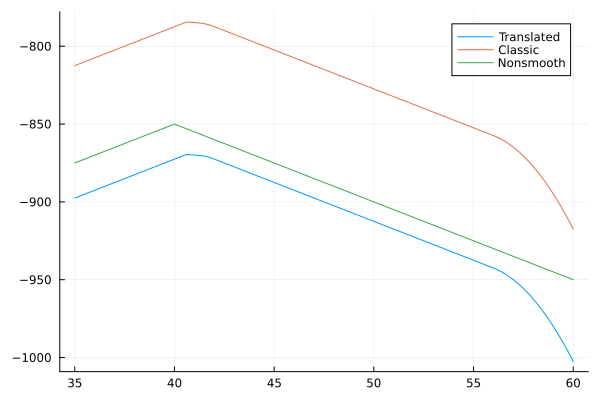

In [58]:
prices = 35:.01:60
translate = Float64[]
classic = Float64[]
nonsmooth = Float64[]
gradtranslate = Float64[]
gradclassic = Float64[]
gradnonsmooth = Float64[]
SMOOTHPAR = 1e-1
shift = UT.GetShift(instance_0)
for price in prices
    ft, gt = UT.exact_translate_smooth_oracle(instance_0, price, SMOOTHPAR, shift)
    fc, gc = UT.exact_smooth_oracle(instance_0, price, SMOOTHPAR)
    fns, gns = UT.exact_oracle(instance_0, price)
    push!(translate, ft)
    push!(classic, fc)
    push!(nonsmooth, fns)
    push!(gradtranslate, gt[1])
    push!(gradclassic, gc[1])
    push!(gradnonsmooth, gns[1])
end

plot(prices, translate, label = "Translated")
plot!(prices, classic, label = "Classic")
plot!(prices, nonsmooth, label = "Nonsmooth")

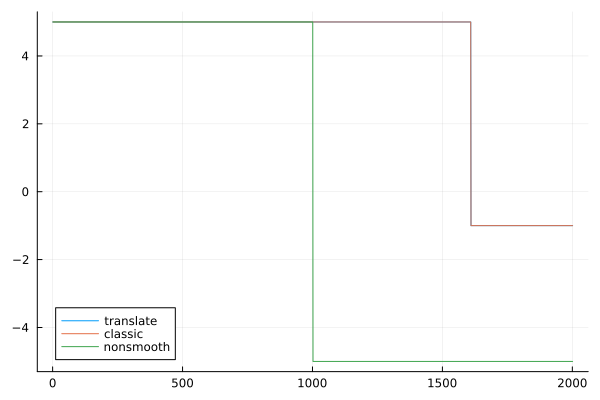

In [56]:
plot(gradtranslate, label = "translate")
plot!(gradclassic, label = "classic")
plot!(gradnonsmooth, label = "nonsmooth")

In [57]:
findall(x->abs(x) < 1, gradtranslate)


Int64[]

In [95]:
shift = UT.GetShift(instance_0)

([1.0 1.0 1.0; 0.0 0.8333333333333333 0.0], [0.0 0.0 0.0; 0.0 0.8333333333333334 0.0], [0.0 0.0 0.0; 0.0 0.0 0.8333333333333334], [15.0 15.0 15.0; 0.0 5.0 0.0], [15.0 15.0 15.0; 0.0 5.0 0.0], [20.0])

In [123]:
xstarGM, itGM, fitGM, timeGM = OPT.tSubgradientMethod(instance_0, [10.], 1, 1.)
xstarGD, itGD, fitGD, timeGD = OPT.tGradientMethod(instance_0, [10.], 1, 1e-6)
xstarDA, itDA, fitDA, timeDA = OPT.tsmoothDAdaptation(instance_0, [10.], 1, 1e1, 1e-6)

#xstarSFGM, itSFGM, fitSFGM, timeSFGM = OPT.tShiftedFastGradientMethod(instance_0, [10.], 2, 1e-6, shift)

([39.29181389688472], [[10.0], [20.0], [22.12678125181665], [24.14213562373095], [26.059101370939324], [27.88854381999832], [29.639610121239315], [31.320071635561042], [32.93658554627822], [34.49489742783179]  …  [40.571617122670965], [39.582202290211384], [40.430407974587546], [39.446191444300744], [40.29113764191427], [39.312039532744706], [40.15376216004931], [39.17970459263785], [40.01823894756817], [39.049145975369214]], Any[-999.9996, -949.9993744999999, -939.3654682409167, -929.2886963813453, -919.7038676453035, -910.5566554000084, -901.8013238938034, -893.3990163221947, -885.3164467686089, -877.524887360841  …  -851.3987974858857, -852.8573596133549, -852.088363048943, -852.1513138729377, -852.7684172784964, -851.4549622095714, -853.4391768362765, -850.7680848002466, -854.1008515368108, -850.0904687378409], [0.0, 0.0019774, 0.0051071, 0.0081645, 0.0108614, 0.0143179, 0.0180038, 0.0209458, 0.0238723, 0.0266735  …  0.9532884, 0.9583765000000001, 0.9630682, 0.96963, 0.9736055, 0.9

In [125]:
fitGD = Float64[]
fitDA = Float64[]
for price in itGD
    push!(fitGD, UT.exact_oracle(instance_0, price)[1])
end

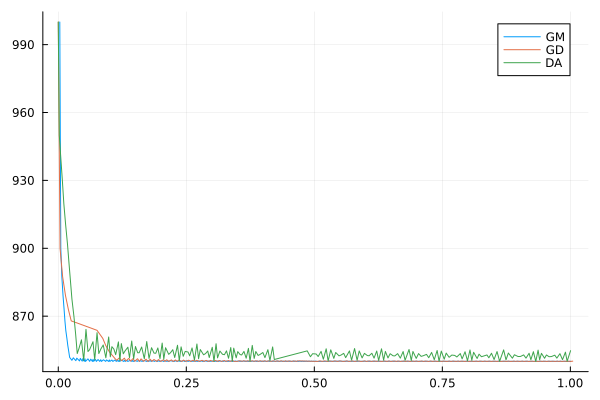

attempt to save state beyond implementation limit


In [131]:
plot(timeGM[2:end], -fitGM, label = "GM")
plot!(timeGD[1:end], -fitGD, label = "GD")
plot!(timeDA[1:end], -fitDA, label = "DA")

In [81]:
@info "GM : $xstarGM, FGM: $xstarFGM, S-FGM: $xstarSFGM"

┌ Info: GM : [34.99999999999999], FGM: [34.99999999999999], S-FGM: [34.99999999999999]
└ @ Main c:\Users\Sofiane\Desktop\ConvexHullPricing\notebooks\checkup.ipynb:1


In [34]:
@info UT.smooth_oracle(instance, LP_Relax, 1e-3)[1]
@info UT.super_fast_oracle(instance, LP_Relax)[1]

┌ Info: -332086.4275
└ @ Main c:\Users\Sofiane\Desktop\ConvexHullPricing\notebooks\checkup.ipynb:1
┌ Info: -332113.0
└ @ Main c:\Users\Sofiane\Desktop\ConvexHullPricing\notebooks\checkup.ipynb:2


In [3]:
instance = UT.load_data("data\\ca\\2015-03-01_reserves_5.json")
LP_Relax = UT.LP_Relaxation(instance)
ObjM = UT.Matching(instance).Obj

-3.115031812256126e9

In [53]:
xstar, itblm, fitblm = OPT.BundleLevelMethod(instance, LP_Relax, N_ITER, .8)

([-95.29905928455031, 198.5827553466611, 481.5270699779177, -66.00091365771101, -67.87591365771101, 481.5270699779177, 46.01010410494803, 209.10220936810094, 2999.9999999171123], [[79.5625, 89.25, 88.0, 86.125, 84.25, 88.0, 84.25, 86.125, 3000.0], [-242.87171052631362, -71.96710526315775, 88.0, -75.0921052631578, -76.96710526315769, 88.0, -76.96710526315769, 86.125, 2484.105263157893], [-95.29905928455031, 198.5827553466611, 481.5270699779177, 195.4577553466611, 193.5827553466611, 481.5270699779177, 46.01010410494803, 209.10220936810094, 2582.4870306522257], [-95.29905928455031, 198.5827553466611, 481.5270699779177, -66.00091365771101, -67.87591365771101, 481.5270699779177, 46.01010410494803, 209.10220936810094, 2791.6539658557226], [-95.29905928455031, 198.5827553466611, 481.5270699779177, -66.00091365771101, -67.87591365771101, 481.5270699779177, 46.01010410494803, 209.10220936810094, 2833.3231726845697], [-95.29905928455031, 198.5827553466611, 481.5270699779177, -66.00091365771101, 

In [54]:
xsg, itsg, fsg = OPT.lastSubgradientMethod(instance, LP_Relax, N_ITER, 100)

([26.61354086124164, 76.01328060118206, 164.0670216777667, 52.46929620071061, 52.11394091172393, 139.418239655135, 50.0848882305283, 90.18283074995755, 3000.0], [[79.5625, 89.25, 88.0, 86.125, 84.25, 88.0, 84.25, 86.125, 3000.0], [74.94894695867926, 86.94322347933962, 88.0, 83.81822347933962, 81.94322347933962, 88.0, 81.94322347933962, 86.125, 2992.618315133887], [68.31264317101125, 83.62507158550561, 88.0, 80.50007158550561, 78.62507158550561, 88.0, 78.62507158550561, 86.125, 2995.272836648954], [70.16595280593954, 87.02280591620749, 92.94215902647547, 83.89780591620749, 82.02280591620749, 92.94215902647547, 80.1694962812792, 87.66942469577359, 2996.508376405573], [63.663715761456736, 83.77168739396609, 92.94215902647547, 80.64668739396609, 78.77168739396609, 92.94215902647547, 76.9183777590378, 87.66942469577359, 2999.1092712233662], [57.22851208856654, 80.55408555752099, 92.94215902647547, 77.42908555752099, 75.55408555752099, 92.94215902647547, 73.7007759225927, 87.66942469577359, 

In [55]:
fitblm = fitblm .- ObjM
fsg = fsg .- ObjM

100-element Vector{Float64}:
 -925.0
 -862.2556786380592
 -742.0300741288811
 -791.1905925866449
 -650.7422724257922
 -749.7190121313324
 -602.716747452796
 -666.4347593749408
 -535.5757994186715
 -548.9785078077693
    ⋮
   -3.940741347381845
   -0.3940741347614676
    0.0
   -2.75851894315565
   -0.3940741347614676
    0.0
   -1.576296538929455
   -0.3940741347614676
    0.0

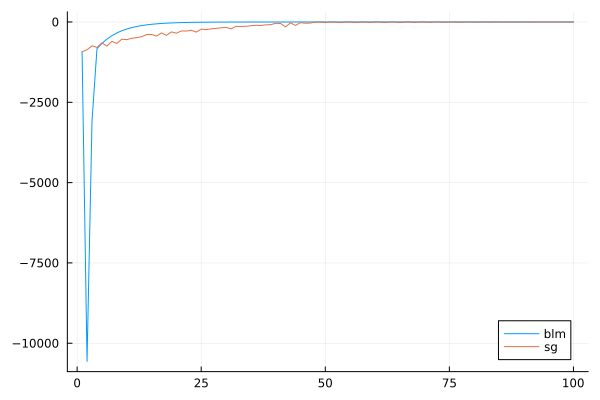

In [57]:
plot(fitblm, label = "blm")
plot!(fsg, label = "sg")

In [ ]:
xcrg, itcrg, fcrg = OPT.ColumnAndRowGeneration(instance, N_ITER, 1e-6)
fcrg = fcrg .- ObjM

In [ ]:
xcg, itcg = OPT.ColumnGeneration(instance, LP_Relax, N_ITER, 1e-6)

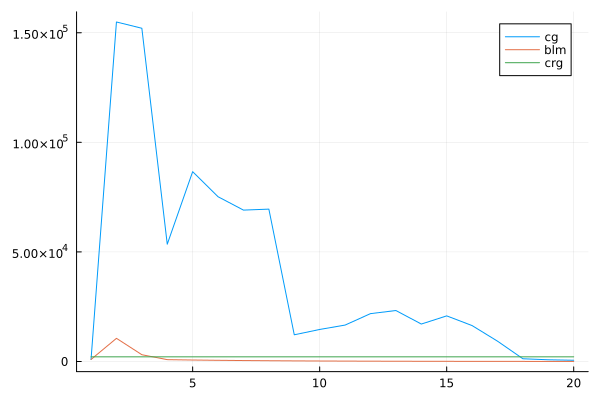

In [200]:
CRGf = []
for x in itcrg
    push!(CRGf, UT.fast_oracle(instance, x)[1] .- ObjM)
end
CGf = []
for x in itcg
    push!(CGf, UT.fast_oracle(instance, x)[1].- ObjM)
end
plot(-CGf, label = "cg")
plot!(-fitblm, label = "blm")
plot!(-CRGf, label = "crg")